# **Assignment 4**

#### **MSc** Scientific and Data Intensive Computing,
#### University College London, 2021-2022

#### Techniques of High Performance Computing (PHAS0102)

###**Cong Zheng** 
### **Student ID: 21055428**

## Contents
#### 1. Introduction
#### 2. Finite difference methods based on explicit time stepping

* ##### 2.1 Explicit CUDA-based implementation
* ##### 2.2 Explicit implementation based on Numba

#### 3. Finite-difference methods based on implicit time stepping
#### 4. Analysis of experimental results

* ##### 4.1 Maximum number of exact bits
* ##### 4.2 Convergence analysis
* ##### 4.3 Stability analysis 

#### 5. Conclusion

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve 
from scipy.sparse import coo_matrix, identity
from sympy import *
from numba import cuda, njit, prange
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

In [ ]:
def plot_temperature(U, Utitle):
    x = np.linspace(-1.0, 1.0, U.shape[0])
    y = np.linspace(-1.0, 1.0, U.shape[1])
    X, Y = np.meshgrid(x,y)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_xlim(-1, 1)
    ax.set_ylim(1, -1)
    ax.set_zlim(0, 5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    surf2 = ax.plot_surface(X, Y, U[:], rstride=1, cstride=1, cmap='viridis', linewidth=0, antialiased=False)
    plt.title(Utitle)
    plt.show()

## 1. Introduction

The problem in this assignment is taken from "In the Moment of Heat" in the SIAM 100 Digit Challenge. As shown in Figure 1, a square plate with sides $[-1, 1] × [-1, 1]$ is heated at t=0 so that the temperature on one side is 5 and the initial temperature everywhere else is 0. The temperature evolves in the manner $u_t=∆u$. Find the time $t^*$ when the temperature at the centre of the plate reaches $u=1$. The ideal 12-digit solution is $t^∗ = 0.424011387033$.

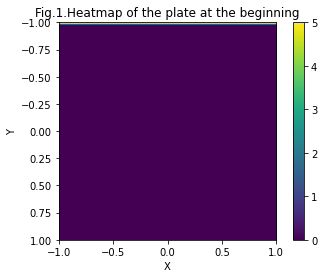

In [ ]:
N = 101
U_Begin = np.zeros((N, N))
U_Begin[0, :] = 5.0
T_actual = 0.424011387033
plt.imshow(U_Begin, extent=(-1,1,1,-1))
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Fig.1.Heatmap of the plate at the beginning')
plt.colorbar()

In this solution, we use the finite difference method to solve the problem. In the second chapter, we completed the finite difference method based on explicit time stepping, in which we used CUDA and Numba computing architectures respectively. In Chapter 3, we implemented the finite difference method based on implicit time stepping. In Chapter 4, we increase the number of discretization points, which proves that this solution can achieve a precision of up to 7 decimal places. In addition, we also discussed the convergence between the actual calculation time and the ideal time and the stability of different solutions.

## 2. Finite difference method based on explicit time stepping

The finite difference method is a basic numerical method in the numerical solution method of PDE. The heat conduction problem is one of the PDE problems based on second-order linear partial differential equations. One way of solving the PDE problem is to express the derivative as a field function and realize the solution of the field function. The Taylor expansion provides us with an implementation form to realize the differentiation of the derivative.

The Taylor expansion form of a function is:
$$
u(x+∆x) = u(x)+\frac{1}{1!}u'(x)∆x+\frac{1}{2!}u''(x)(∆x)^2+ ...
$$
$$
u(x-∆x) = u(x)-\frac{1}{1!}u'(x)∆x+\frac{1}{2!}u''(x)(∆x)^2 +...
$$

Adding the above two formulas and eliminating the first-order derivative, the three-point center difference formula of the second-order derivative can be obtained:

$$
u''(x) = \frac{u(x+∆x)+u(x-∆x)-2u(x)}{∆x^2}
$$

$$
u''(y) = \frac{u(y+∆y)+u(y-∆y)-2u(y)}{∆y^2}
$$

For the two-dimensional heat conduction problem in the title, the spatial propagation law follows the second-order linear partial differential equation, as shown below.

$$
\frac{\partial^2 u(x)}{\partial x^2}+
\frac{\partial^2 u(y)}{\partial y^2}
=\frac{\partial u(t)}{\partial t}
$$

In the previous Taylor expansion, if the higher-order terms are ignored, we can get the forward propagation formula as:

$$
u'(x)
=\frac{u(x+∆x)-u(x)}{∆x}
$$

For the problem of heat conduction, the propagation law is isotropic in space, that is, it is a uniform equation. Therefore, the forward propagation formula can be obtained as follows:

$$
\frac{u(x+∆x)+u(x-∆x)+u(y+∆y)+u(y-∆y)-4u(x,y)}{\partial ∆x^2}
=\frac{u(t+∆t)-u(t)}{∆t}
$$

In order to discuss various solutions, we set the Courant number as $C$.

$$
C=\frac{∆t}{∆x^2}
$$

Based on the above formulas, we can rewrite it slightly to get:

$$
C[u_t(i+1,j)+u_t(i-1,j)+u_t(i,j+1)+u_t(i,j-1)]+(1-4C)u_t(i,j)
=u_{t+1}(i,j)
$$

This equation is a governing equation for non-steady-state problems. Based on the distribution of the field function at the previous moment, we can get the distribution of the field at the next moment. Therefore, we can use the idea of ​​iteration. When it is at the initial moment, due to the existence of the initial conditions, we can get the state distribution at the next moment, and then iterate gradually.

### 2.1 Explicit implementation based on CUDA

First, we completed the finite difference method based on CUDA with explicit time stepping.

Specifically, we wrote a CUDA kernel function named explicit_cuda_step. This function is based on the formula obtained before, and performs an iterative update calculation of the matrix.

In [ ]:
@cuda.jit
def explicit_cuda_step(U1, U2, U_Central, N, M, Iteration):
    i_Iteration, j_Iteration = cuda.grid(2)
    C = ((N - 1) * (N - 1)) / (4 * (M - 1))
    if i_Iteration > 0 and i_Iteration < N-1 and j_Iteration > 0 and j_Iteration < N-1:
        if Iteration%2 == 0:
            U1[i_Iteration,j_Iteration]=(1-4*C)*U2[i_Iteration,j_Iteration]+C*(U2[i_Iteration-1,j_Iteration]+U2[i_Iteration+1,j_Iteration]+U2[i_Iteration,j_Iteration-1]+U2[i_Iteration,j_Iteration+1])
            U_Central[Iteration] = U1[int((N - 1)/ 2), int((N - 1)/2)]
            cuda.syncthreads()
        else:
            U2[i_Iteration,j_Iteration]=(1-4*C)*U1[i_Iteration,j_Iteration]+C*(U1[i_Iteration-1,j_Iteration]+U1[i_Iteration+1,j_Iteration]+U1[i_Iteration,j_Iteration-1]+U1[i_Iteration,j_Iteration+1])
            U_Central[Iteration] = U2[int((N - 1)/ 2), int((N - 1)/2)]
            cuda.syncthreads()
    else:
        return

In addition, we also designed the explicit_cuda function. The parameters of this function are the matrix dimension $N$ and the time steps number $M$, and return the temperature matrix and the calculation time when the center temperature of the plate reaches 1.0. Among them, we have opened up two global spaces U1_device and U2_device on the device side to store and update the calculation data of the matrix in turn, and opened up a global space U_Central_device to store the temperature data at the center point of the matrix during each iteration.

In [ ]:
def explicit_cuda(N, M):
    blockdim = (32, 32)
    gridx = (N+(blockdim[0]-1))//blockdim[0]
    gridy = (N+(blockdim[1]-1))//blockdim[1]
    griddim = (gridx, gridy)
    Iteration = 0
    U1_device = cuda.device_array((N, N), dtype = np.float64)
    U2_device = cuda.device_array((N, N), dtype = np.float64)
    U_Central_device = cuda.device_array(M, dtype = np.float64)
    for i_Iteration in range(N):
        for j_Iteration in range(N):
            if i_Iteration == 0:
                U1_device[i_Iteration,j_Iteration] = 5.0
                U2_device[i_Iteration,j_Iteration] = 5.0
            else:
                U1_device[i_Iteration,j_Iteration] = 0.0
                U2_device[i_Iteration,j_Iteration] = 0.0             
    for i in range(int(M*0.43)):
        explicit_cuda_step[griddim, blockdim](U1_device, U2_device, U_Central_device, N, M, i)

    U_Central_host = U_Central_device.copy_to_host()
    for i in range(int(M*0.43)):
        if U_Central_host[i] >= 1.0:
            Iteration = i 
            break
    if Iteration%2 == 1:
        U_host = U1_device.copy_to_host()
    else:
        U_host = U2_device.copy_to_host()
    Res_T = Iteration / (M - 1)
    return U_host, Res_T

Next, we set the matrix dimension $N=101$, the total number of time steps is $M=80001$, and use this method to calculate, and draw the instantaneous plate temperature image when the center point is greater than 1.0.

Actual calculation time: 0.4239875000000000


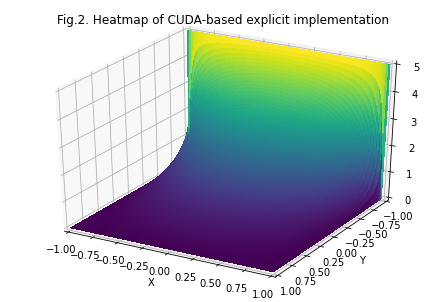

In [ ]:
U_ex_cuda, T_ex_cuda = explicit_cuda(101, 80001)
print("Actual calculation time: {:.16f}".format(T_ex_cuda))
plot_temperature(U_ex_cuda,'Fig.2. Heatmap of CUDA-based explicit implementation')

Observing the image and output, when the matrix dimension $N=101$ and the total time steps are $M=80001$, the time calculated by this scheme is $0.4239875000000000$, which is compared to the ideal mentioned in Chapter 1. Time $t^∗ = 0.424011387033$, this solution only achieves 2 decimal places of precision.

### 2.2 Explicit implementation based on Numba

In addition, we also implemented an explicit stepping scheme based on Numba.

In [ ]:
@njit(parallel = True)
def explicit_numba_step(N, M, C, U_Iteration):
    U1_Iteration = np.copy(U_Iteration)
    for i in prange(1, N - 1):
        for j in range(1, N - 1):
            U1_Iteration[i, j] = (1-4*C)*U_Iteration[i,j] + C*(U_Iteration[i-1,j]+U_Iteration[i+1,j]+U_Iteration[i,j-1]+U_Iteration[i,j+1])
    return U1_Iteration

In [ ]:
def explicit_numba(N, M):
    Current_Num = ((N - 1) * (N - 1)) / (4 * (M - 1))
    U_Iteration = np.zeros((N, N), dtype=np.float64)
    U_Iteration[0, :] = 5.0
    Iteration = 0    
    while U_Iteration[int((N - 1)/2), int((N - 1)/2)] < 1.0:
        U_Iteration = explicit_numba_step(N, M, Current_Num, U_Iteration)
        Iteration = Iteration + 1
    Res_T = Iteration / (M - 1)
    return U_Iteration, Res_T

T: 0.4240000000000000


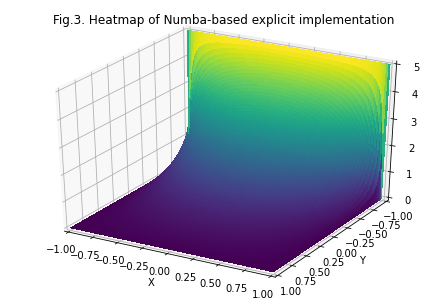

In [ ]:
U_ex_numba, T_ex_numba = explicit_numba(101, 80001)
print("T: {:.16f}".format(T_ex_numba))
plot_temperature(U_ex_numba,'Fig.3. Heatmap of Numba-based explicit implementation')

Observing the image and output, when the matrix dimension is $N=101$ and the total time steps are $M=80001$, the time calculated by this scheme is $0.4240000000000000$, which is compared to the ideal mentioned in Chapter 1. Time $t^∗ = 0.424011387033$, this solution achieves 4 decimal places of precision. With the further discretization of time and space, the accuracy is expected to be further improved.

## 3. Finite difference method based on implicit time stepping

Similar to Chapter 2, when using the two points of point $x$ and point $x-∆x$ to construct, we can get the two-point backward difference formula of the first derivative.

$$
u'(x)
=\frac{u(x)-u(x-∆x)}{∆x}
$$

Similarly, we can get the implicit time step formula based on backward difference, as shown below.

$$
\frac{u(x+∆x)+u(x-∆x)+u(y+∆y)+u(y-∆y)-4u(x,y)}{\partial ∆x^2}
=\frac{u(x)-u(x-∆x)}{∆x}
$$

With a little rewriting, you can get:

$$
u_t(i,j)=
-C[u_{t+1}(i+1,j)+u_{t+1}(i-1,j)+u_{t+1}(i,j+1)+u_{t+1 }(i,j-1)]+(1+4C)u_{t+1}(i,j)
$$

That is:

$$
(I-∆tA) u_{t+1} = u_t
$$

where $I$ is the identity matrix and $A$ is the matrix generated by discretise_poisson function.

Observing the above formula, it is not difficult to find that because the backward difference is an implicit difference form, it is impossible to explicitly express the relationship between the next moment and the previous moment. Therefore, linear equations need to be solved in each iteration. And we use the sparse matrix direct solver spsolve command to solve instead of iterative method.

Based on the above ideas, we can write a solution based on implicit time stepping.

In [ ]:
def discretise_improved_poisson(N):
    """Generate the matrix and rhs associated with the discrete Poisson operator."""
    
    nelements = 5 * N**2 - 16 * N + 16

    h = 2/(N-1)
    
    row_Iteration = np.empty(nelements, dtype=np.float64)
    col_Iteration = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)
    
    Iteration = 0
    for j_Iteration in range(N):
        for i_Iteration in range(N):
            if i_Iteration == 0 or i_Iteration == N - 1 or j_Iteration == 0 or j_Iteration == N - 1:
                row_Iteration[Iteration] = col_Iteration[Iteration] = j_Iteration * N + i_Iteration
                data[Iteration] =  1
                Iteration += 1
                
            else:
                row_Iteration[Iteration : Iteration + 5] = j_Iteration * N + i_Iteration
                col_Iteration[Iteration] = j_Iteration * N + i_Iteration
                col_Iteration[Iteration + 1] = j_Iteration * N + i_Iteration + 1
                col_Iteration[Iteration + 2] = j_Iteration * N + i_Iteration - 1
                col_Iteration[Iteration + 3] = (j_Iteration + 1) * N + i_Iteration
                col_Iteration[Iteration + 4] = (j_Iteration - 1) * N + i_Iteration
                                
                data[Iteration] = -4 / (h**2)
                data[Iteration + 1 : Iteration + 5] =  1/(h**2)
                
                Iteration += 5
                                                
    return coo_matrix((data, (row_Iteration, col_Iteration)), shape=(N**2, N**2)).tocsr()

In [ ]:
def implicit(N, M):

    A_matrix = discretise_improved_poisson(N)
    dt = 1/(M-1)
    Current_Num = ((N - 1) * (N - 1)) / (4 * (M - 1))

    print("C: {}".format(Current_Num))

    I_matrix = identity(N*N)

    U_implicit = np.zeros((N, N), dtype=np.float64)
    U_implicit[0, :] = 5.0

    Iteration = 0
        
    while U_implicit[int((N - 1)/2), int((N - 1)/2)] < 1.0:
        U_implicit = U_implicit.reshape((N*N))
        U_implicit_1 = spsolve((I_matrix-dt*A_matrix), U_implicit)
        U_implicit_1 = U_implicit_1.reshape((N, N))
        U_implicit_1[0,:] = 5
        U_implicit = U_implicit_1.copy()
        Iteration = Iteration + 1

    Res_T = Iteration * dt

    return U, Res_T

Next, we set the matrix dimension $N=51$, the total time steps are $M=10001$, and use this method to calculate, and draw the instantaneous plate temperature image when the center point is greater than 1.0.

C: 0.0625
0.42410000000000003


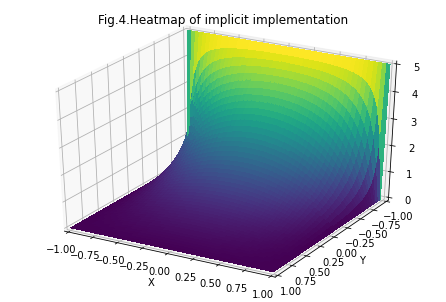

In [ ]:
U_im, T_im = implicit(51, 10001)
print(T_im)
plot_temperature(U_im,'Fig.4.Heatmap of implicit implementation')

Observing the image and output, when the matrix dimension $N=51$ and the total number of time steps is $M=10001$, the time calculated by this scheme is $42410000000000003$, which is compared to the ideal mentioned in Chapter 1. Time $t^∗ = 0.424011387033$, this solution only achieves 3 decimal places of precision.

## 4. Analysis of Experimental Results

### 4.1 Maximum number of precise digits

In this solution, in order to get as close as possible to the ideal time $t^∗ = 0.424011387033$, we continue to increase the amount of discrete points, and test the combination of multiple sets of matrix dimensions $N$ and the total amount of time steps $M$. Among them, when the matrix dimension is $N=201$ and the total amount of time steps is $M=2560001$, the time calculated by this scheme is $0.4240113281250000$, and the scheme achieves an accuracy of 7 digits after the decimal point.

T: 0.4240113281250000


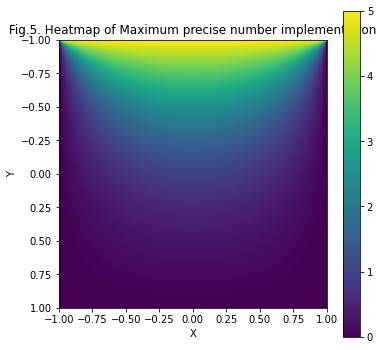

In [ ]:
U_ex_numba_max, T_ex_numba_max = explicit_numba(201, 2560001)
print("T: {:.16f}".format(T_ex_numba_max))

plt.figure(figsize=(6,6))
plt.imshow(U_ex_numba_max, extent=(-1,1,1,-1))
plt.title('Fig.5. Heatmap of Maximum precise number implementation')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()

### 4.2 Convergence analysis

In order to analyze the convergence, we use the controlled variable method. First, the method of fixing the total number of time steps $M$ is used to increase the matrix dimension size $N$. After that, the fixed matrix dimension $N$ is used to increase the total number of time steps $M$.

In [ ]:
Dim = np.array([11, 31, 51, 71, 91])
Tim = np.array([3001, 4001, 5001, 6001, 7001])
Dxs =  np.zeros(5)
Res_0_ex = np.zeros(5)
Res_1_ex = np.zeros(5)
Res_2_ex = np.zeros(5)
Res_3_ex = np.zeros(5)
for n in range(len(Dim)):
    _, Res_T_0_ex = explicit_cuda(Dim[n],10001)
    _, Res_T_1_ex = implicit(Dim[n], 10001)
    _, Res_T_2_ex = explicit_cuda(51, Tim[n])
    _, Res_T_3_ex = implicit(51, Tim[n])
    Res_0_ex[n] = np.abs((Res_T_0_ex - T_actual) / T_actual)
    Res_1_ex[n] = np.abs((Res_T_1_ex - T_actual) / T_actual)
    Res_2_ex[n] = np.abs((Res_T_2_ex - T_actual) / T_actual)
    Res_3_ex[n] = np.abs((Res_T_3_ex - T_actual) / T_actual)
    Dxs[n] = 2/(Dim[n]-1)

In order to show the convergence more clearly, we have drawn several sets of schematic diagrams of relative error changes in different situations, as shown in Figures 6 and 7.

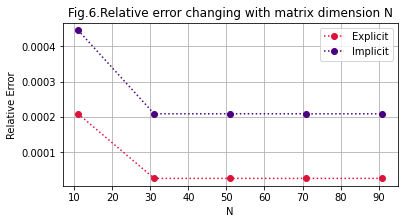

In [ ]:
plt.figure(figsize=(6, 3))
plt.plot(Dim, Res_0_ex, ':',label = 'Explicit',color='crimson', marker ='o')
plt.plot(Dim, Res_1_ex, ':',label = 'Implicit',color='indigo', marker = 'o')
plt.title('Fig.6.Relative error changing with matrix dimension N')
plt.xlabel('N')
plt.ylabel('Relative Error')
plt.grid()
plt.legend()
plt.show()

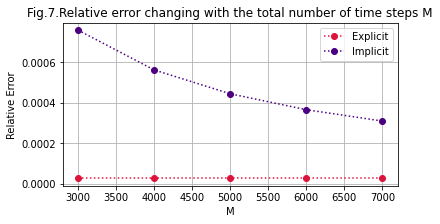

In [ ]:
plt.figure(figsize=(6, 3))
plt.plot(Tim, Res_2_ex, ':',label = 'Explicit',color='crimson', marker ='o')
plt.plot(Tim, Res_3_ex, ':',label = 'Implicit',color='indigo', marker ='o')
plt.title('Fig.7.Relative error changing with the total number of time steps M')
plt.xlabel('M')
plt.ylabel('Relative Error')
plt.grid()
plt.legend()
plt.show()

Observing Figure 6 and Figure 7, we can get that whether it is explicit or implicit, as the degree of discretization increases, that is, the matrix dimension $N$ and the total number of time steps $M$ increase, the relative error becomes more and more. small. In this example, the overall relative error of the explicit method is smaller than that of the implicit method, which means that the explicit method has better accuracy and convergence under this value.

In addition, in order to verify whether the second-order finite difference of space and the first-order finite difference of time are second-order convergence, we set the matrix dimensions $N$ to be $26, 51, 101, 201, 401$ respectively, and by changing $M$ to keep the Courant number $C$ at 0.25 and 0.125 respectively.

In [ ]:
Dim_con = np.array([26, 51, 101, 201, 401])
Tim_0 = np.array([626, 2501, 10001, 40001, 160001])
Tim_1 = np.array([1251, 5001, 20001, 80001, 320001])
Dxs_con =  np.zeros(5)
Dts_0 =  np.zeros(5)
Dts_1 =  np.zeros(5)
Res_0 = np.zeros(5)
Res_1 = np.zeros(5)
for n in range(len(Dim_con)): 
    _, Res_T_0 = explicit_numba(Dim_con[n], Tim_0[n])
    _, Res_T_1 = explicit_numba(Dim_con[n], Tim_1[n])
    Res_0[n] = np.abs((Res_T_0 - T_actual) / T_actual)
    Res_1[n] = np.abs((Res_T_1 - T_actual) / T_actual)
    Dxs_con[n] = 2/(Dim_con[n]-1)
    Dts_0[n] = 1/(Tim_0[n]-1)
    Dts_1[n] = 1/(Tim_1[n]-1)

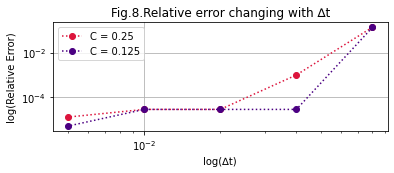

In [ ]:
plt.figure(figsize=(6, 2))
plt.loglog(Dxs_con, Res_0, ':',label = 'C = 0.25',color='crimson', marker ='o')
plt.loglog(Dxs_con, Res_1, ':',label = 'C = 0.125',color='indigo', marker = 'o')
plt.title('Fig.8.Relative error changing with ∆t')
plt.xlabel('log(∆t)')
plt.ylabel('log(Relative Error)')
plt.grid()
plt.legend()
plt.show()

Observing Figure 8 shows that the explicit and implicit solution methods both converge with second-order accuracy for the time step.

### 4.3 Stability analysis

In the previous analysis, it is not difficult to find that the realization of the finite difference method with explicit time stepping has the problem of instability. When the Courant number $C$ is greater than 0.25, the implementation scheme will be unstable. For example, we set the matrix dimension $N = 101$, the total number of time steps $M = 5001$, according to the definition of Courant number, the value of Courant number is $0.5$, as shown in the figure.

C: 0.5


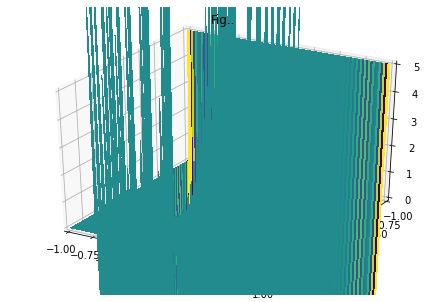

0.0202


In [ ]:
U_ex_st, T_ex_st = explicit_numba(101, 5001)
plot_temperature(U_ex_st,'Fig.9.Heatmap of explicitly implement')
print(T_ex_st)

Observing the graph, we can see that the explicit solution at this time is very unstable and does not converge, and it is impossible to find the correct solution time.

The implicit solution scheme has no such disadvantages. Similarly, we set the matrix dimension $N = 101$, and the total number of time steps $M = 5001$. According to the definition of Courant number, the Courant number of this value is also $0.5$, as shown in the figure below.

C: 0.5


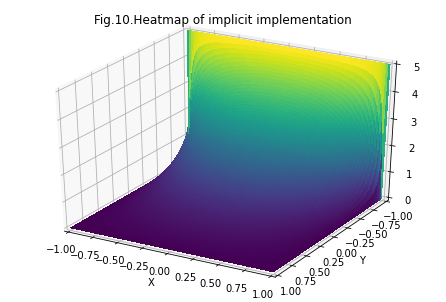

0.4242


In [ ]:
U_im_st, T_im_st = implicit(101, 5001)
plot_temperature(U_im_st,'Fig.10.Heatmap of implicit implementation')
print(T_im_st)

Observing the comparison of the two figures, we can see that for this same situation, the implicit solution scheme can be solved correctly, and it is convergent and stable.

The forward form is concise and clear, but its stability and convergence require the Courant number. In the two-dimensional heat conduction problem in this example, the Courant number $C$ must be less than or equal to 0.25. This makes the matrix dimension $N$ and the total number of steps $M$ limited. The earth limits the description range of the numerical solution. The backward difference solution is unconditionally stable, so there is a lot of freedom in the selection of parameters.

## 5. Conclusion

In this solution, we use the finite difference method to solve the two-dimensional plane heat conduction problem. We completed the explicit scheme based on CUDA and Numba architecture, and completed the finite difference method of implicit time stepping. In addition, we increase the number of discretization points to achieve a precision of 7 digits after the decimal point at most, and discuss the convergence between the actual calculation time and the ideal time and the stability of different schemes. In fact, the explicit solution has faster solution speed and accuracy, while the implicit solution has better convergence and stability.

Due to the limitation of time and the author's own knowledge level, there are many areas to be improved in this solution. For example, there is no further discussion on the relationship between Courant number and convergence, no theoretical proof of time step, space step, and convergence order, no shared memory optimization access, and so on. In future research, how to use new mathematical theories and computing frameworks to achieve a more precise solution to this problem is the future research direction.